# Urn Task

This notebook tests whether a model behaves like a Bayesian observer on a two-urn sequential inference task.

In [29]:
# !pip -q install transformer_lens circuitsvis einops pandas numpy matplotlib tqdm scikit-learn huggingface_hub

# Plotly renderer (CircuitVis)
try:
    import plotly.io as pio
    pio.renderers.default = 'notebook_connected'
except Exception as e:
    print('Plotly renderer not set:', e)


In [30]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_act_name

import circuitsvis as cv
from IPython.display import display

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

try:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    pass

print('Seeds set to', SEED)


Seeds set to 42


In [31]:
# huggingface login
from huggingface_hub import login

# login()

import os
hf_token = os.getenv('HF_TOKEN', None)
if hf_token:
    login(token=hf_token)
    print('Logged in to Hugging Face')
else:
    print('HF_TOKEN not set. Use interactive login() or set HF_TOKEN environment variable.')


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Logged in to Hugging Face


In [32]:
# global configuration

# Model + device
# MODEL_ID = 'meta-llama/Llama-3.2-3B'
MODEL_ID = "attn-only-3l"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float16 if DEVICE == 'cuda' else torch.float32

# core urn parameters (used everywhere)
urn_A_pX = 0.75
urn_B_pX = 0.25
prior_P_A = 0.5

# prompt template (natural language)
# v0: shortest / least mathy
# v1-v3: longer paraphrases
prompt_template_version = 'v1'  # v0 | v1 | v2 | v3

# Forced-choice readout tokens
# Answer labels are A/B; they correspond to X/Y outcomes.
ANSWER_TOKEN_A = ' A'
ANSWER_TOKEN_B = ' B'
ANSWER_MEANS = {'A': 'X', 'B': 'Y'}

# Output directory
output_dir = 'results_urn_task'
os.makedirs(output_dir, exist_ok=True)

print('MODEL_ID:', MODEL_ID)
print('DEVICE:', DEVICE, 'DTYPE:', DTYPE)
print('Task: A_pX=%.2f B_pX=%.2f prior=%.2f' % (urn_A_pX, urn_B_pX, prior_P_A))
print('Prompt template:', prompt_template_version)
print('Output dir:', output_dir)


MODEL_ID: attn-only-3l
DEVICE: cuda DTYPE: torch.float16
Task: A_pX=0.75 B_pX=0.25 prior=0.50
Prompt template: v1
Output dir: results_urn_task


In [33]:
# load model with TransformerLens

model = HookedTransformer.from_pretrained(MODEL_ID, device=DEVICE, dtype=DTYPE)
model.eval()

print('Loaded', MODEL_ID)
print('n_layers:', model.cfg.n_layers, 'n_heads:', model.cfg.n_heads, 'd_model:', model.cfg.d_model)
print('tokenizer:', type(model.tokenizer))


config.json: 0.00B [00:00, ?B/s]

./model_final.pth:   0%|          | 0.00/216M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Loaded pretrained model attn-only-3l into HookedTransformer
Loaded attn-only-3l
n_layers: 3 n_heads: 8 d_model: 512
tokenizer: <class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>


In [34]:
# tokenization sanity checks (strict)


def assert_single_token(text):
    ids = model.tokenizer.encode(text, add_special_tokens=False)
    if len(ids) != 1:
        raise RuntimeError(f'Tokenization error: {text!r} is not a single token (ids={ids}). Choose another label.')
    return ids[0]

# Check answer tokens
A_id = assert_single_token(ANSWER_TOKEN_A)
B_id = assert_single_token(ANSWER_TOKEN_B)

print('Chosen answer tokens:')
print('A token:', repr(ANSWER_TOKEN_A), 'id=', A_id, 'decoded=', model.tokenizer.decode([A_id]))
print('B token:', repr(ANSWER_TOKEN_B), 'id=', B_id, 'decoded=', model.tokenizer.decode([B_id]))

# Also check plain A/B for info
for s in ['A','B']:
    ids = model.tokenizer.encode(s, add_special_tokens=False)
    print('Tokenization for', repr(s), '->', ids)

# Observation symbol tokens (X/Y)
obs_tokens = ['X','Y',' X',' Y']
print('Observation tokenization lengths:')
for s in obs_tokens:
    ids = model.tokenizer.encode(s, add_special_tokens=False)
    print(repr(s), 'len=', len(ids), 'ids=', ids)


Chosen answer tokens:
A token: ' A' id= 330 decoded=  A
B token: ' B' id= 378 decoded=  B
Tokenization for 'A' -> [35]
Tokenization for 'B' -> [36]
Observation tokenization lengths:
'X' len= 1 ids= [58]
'Y' len= 1 ids= [59]
' X' len= 1 ids= [1558]
' Y' len= 1 ids= [712]


In [35]:
# urn task math engine (ground truth Bayes)


def bayes_update_posterior(prior_P_A, pX_A, pX_B, obs_seq):
    pA = prior_P_A
    for obs in obs_seq:
        if obs == 'X':
            lik_A = pX_A
            lik_B = pX_B
        else:
            lik_A = 1 - pX_A
            lik_B = 1 - pX_B
        unnorm_A = lik_A * pA
        unnorm_B = lik_B * (1 - pA)
        denom = unnorm_A + unnorm_B
        pA = unnorm_A / denom if denom > 0 else 0.5
    return pA


def bayes_predictive(posterior_P_A, pX_A, pX_B):
    return posterior_P_A * pX_A + (1 - posterior_P_A) * pX_B


def logodds(p):
    p = max(1e-9, min(1 - 1e-9, p))
    return math.log(p / (1 - p))


def compute_truth_table(obs_seq, prior_P_A, pX_A, pX_B, laplace=0.0):
    rows = []
    pA = prior_P_A
    nX = 0
    for t, obs in enumerate(obs_seq, start=1):
        if obs == 'X':
            nX += 1
        pA = bayes_update_posterior(prior_P_A, pX_A, pX_B, obs_seq[:t])
        p_next_X = bayes_predictive(pA, pX_A, pX_B)
        denom = t + 2 * laplace if laplace > 0 else t
        p_hat = (nX + laplace) / denom if denom > 0 else 0.5
        rows.append({
            'step': t,
            'obs': obs,
            'posterior_P_A': pA,
            'bayes_P_next_X': p_next_X,
            'bayes_logodds': logodds(p_next_X),
            'freq_Phat_X': p_hat,
        })
    return pd.DataFrame(rows)

print('Example truth table:')
print(compute_truth_table(['X','Y','X'], prior_P_A, urn_A_pX, urn_B_pX))


Example truth table:
   step obs  posterior_P_A  bayes_P_next_X  bayes_logodds  freq_Phat_X
0     1   X           0.75           0.625       0.510826     1.000000
1     2   Y           0.50           0.500       0.000000     0.500000
2     3   X           0.75           0.625       0.510826     0.666667


In [36]:
# prompt design (behavioral, not calculation)

TEMPLATES = {
    'v0': (
        'There are two urns that produce J or Y. Urn A is biased toward X, and Urn B is biased toward Y.\n'
        'So far we have seen: {seq}.\n'
        'Next is more likely?\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    ),
    'v1': (
        'Two urns produce X/Y. Urn A produces X about {pA_pct:.0f}%% of the time, Urn B produces X about {pB_pct:.0f}%% of the time.\n'
        'Observed sequence: {seq}.\n'
        'Which is more likely next?\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    ),
    'v2': (
        'We have two generators. Urn A gives X roughly {pA_pct:.0f}%% of the time; Urn B gives X roughly {pB_pct:.0f}%% of the time.\n'
        'Sequence so far: {seq}.\n'
        'Next is more likely?\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    ),
    'v3': (
        'Urn A tends to give X; Urn B tends to give Y. In numbers: A gives X about {pA_pct:.0f}%%, B gives X about {pB_pct:.0f}%%.\n'
        'Evidence: {seq}.\n'
        'Choose the more likely next symbol.\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    ),
}


def build_prompt(obs_seq, pA, pB, prior, template_id='v1'):
    seq_str = ' '.join(obs_seq) if len(obs_seq) > 0 else '(none yet)'
    return TEMPLATES[template_id].format(
        pA=pA,
        pB=pB,
        pA_pct=100 * pA,
        pB_pct=100 * pB,
        prior=prior,
        seq=seq_str,
    )

print(build_prompt(['X','Y','X'], urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))

Two urns produce X/Y. Urn A produces X about 75%% of the time, Urn B produces X about 25%% of the time.
Observed sequence: X Y X.
Which is more likely next?
A) X
B) Y
Answer:


In [37]:
# extract model belief from logits (forced-choice readout)

@torch.no_grad()
def get_ab_logprobs(prompt_str, token_id_A, token_id_B):
    logits = model(prompt_str)
    last = logits[0, -1, :]
    logit_A = float(last[token_id_A].item())
    logit_B = float(last[token_id_B].item())
    probs = torch.softmax(last.float(), dim=-1)
    pA = float(probs[token_id_A].item())
    pB = float(probs[token_id_B].item())
    denom = pA + pB
    pA_norm = pA / denom if denom > 0 else 0.5
    pB_norm = pB / denom if denom > 0 else 0.5
    logodds_AB = math.log(pA_norm / pB_norm) if pA_norm > 0 and pB_norm > 0 else 0.0
    return {
        'logit_A': logit_A,
        'logit_B': logit_B,
        'pA_norm': pA_norm,
        'pB_norm': pB_norm,
        'logodds_AB': logodds_AB,
    }

prompt = build_prompt(['X','Y','X'], urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
print(get_ab_logprobs(prompt, A_id, B_id))


{'logit_A': 14.1015625, 'logit_B': 12.0703125, 'pA_norm': 0.8840392829074983, 'pB_norm': 0.1159607170925017, 'logodds_AB': 2.0312500113298375}


In [38]:
# episode config (edit before running behavioral/batch/probe sections)
seq_len_single = 20
seq_len_batch = 20
n_batch_episodes = 300


,step,obs_t,true_hidden_urn,bayes_P_next_X,model_P_next_X,freq_Phat_X,bayes_logodds,model_logodds
0,1,X,B,0.625,0.869715,1.000000,0.510826,1.898438
1,2,Y,B,0.500,0.874077,0.500000,0.000000,1.937500
2,3,X,B,0.625,0.884039,0.666667,0.510826,2.031250
3,4,Y,B,0.500,0.886420,0.500000,0.000000,2.054688
4,5,Y,B,0.375,0.888759,0.400000,-0.510826,2.078125


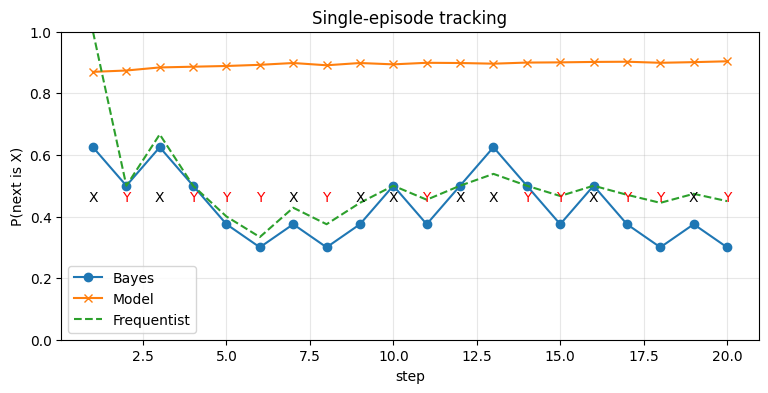

MAE: 0.4590247516898251 Bias: 0.4590247516898251 Corr: -0.5090989485825421


In [39]:
# single-episode demo (dynamic sequence)

hidden_urn = 'A' if random.random() < prior_P_A else 'B'
true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX

obs_seq = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_single)]

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
    model_out = get_ab_logprobs(prompt, A_id, B_id)

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])
    bayes_logodds = float(truth.iloc[-1]['bayes_logodds'])
    freq_p = float(truth.iloc[-1]['freq_Phat_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'true_hidden_urn': hidden_urn,
        'bayes_P_next_X': bayes_p,
        'model_P_next_X': model_out['pA_norm'],
        'freq_Phat_X': freq_p,
        'bayes_logodds': bayes_logodds,
        'model_logodds': model_out['logodds_AB'],
    })

single_df = pd.DataFrame(rows)
display(single_df.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(single_df.step, single_df.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(single_df.step, single_df.model_P_next_X, label='Model', marker='x')
ax.plot(single_df.step, single_df.freq_Phat_X, label='Frequentist', linestyle='--')

for i, tok in enumerate(single_df.obs_t):
    ax.annotate(tok, (single_df.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode tracking')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

mae = float((single_df.model_P_next_X - single_df.bayes_P_next_X).abs().mean())
bias = float((single_df.model_P_next_X - single_df.bayes_P_next_X).mean())
corr = float(np.corrcoef(single_df.model_P_next_X, single_df.bayes_P_next_X)[0, 1])
print('MAE:', mae, 'Bias:', bias, 'Corr:', corr)


In [40]:
# format-bias diagnostics (run after single-episode demo)

def readout_AB(prompt):
    out = get_ab_logprobs(prompt, A_id, B_id)
    return out['pA_norm']

def readout_XY(prompt):
    x_id = assert_single_token(' X')
    y_id = assert_single_token(' Y')
    logits = model(prompt)[0, -1, :]
    probs = torch.softmax(logits.float(), dim=-1)
    pX = float(probs[x_id].item())
    pY = float(probs[y_id].item())
    denom = pX + pY
    return pX / denom if denom > 0 else 0.5

balanced_prefix = ['X','Y','X','Y']
empty_prefix = []

# 1) Empty evidence or balanced prefix (A/B format)
prompt_empty = build_prompt(empty_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
prompt_bal = build_prompt(balanced_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
print('p(A|{A,B}) empty:', readout_AB(prompt_empty))
print('p(A|{A,B}) balanced:', readout_AB(prompt_bal))

# 2) Swap option order (A=Y, B=X) but keep same A/B readout
swap_prompt = build_prompt(balanced_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
swap_prompt = swap_prompt.replace('A) X', 'A) Y').replace('B) Y', 'B) X')
print('p(A|{A,B}) with swapped options:', readout_AB(swap_prompt))

# 3) Remove A/B: direct X/Y answer
seq_str = ' '.join(balanced_prefix) if balanced_prefix else '(none yet)'
xy_prompt = (
    'There are two urns that produce X or Y. Urn A is biased toward X, and Urn B is biased toward Y.\n'
    f'So far we have seen: {seq_str}.\n'
    'Answer with X or Y:'
)
print('p(X|{X,Y}) direct answer:', readout_XY(xy_prompt))

p(A|{A,B}) empty: 0.8652240799367318
p(A|{A,B}) balanced: 0.8864204162434007
p(A|{A,B}) with swapped options: 0.8824278657147905
p(X|{X,Y}) direct answer: 0.5253688216152044


In [41]:
# batch evaluation (no ablation)

rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
        model_out = get_ab_logprobs(prompt, A_id, B_id)

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'ep': ep,
            't': t,
            'bayes_P_next_X': bayes_p,
            'model_P_next_X': model_out['pA_norm'],
        })

all_df = pd.DataFrame(rows)

mae = float((all_df.model_P_next_X - all_df.bayes_P_next_X).abs().mean())
bias = float((all_df.model_P_next_X - all_df.bayes_P_next_X).mean())
corr = float(np.corrcoef(all_df.model_P_next_X, all_df.bayes_P_next_X)[0, 1])

summary = pd.DataFrame([{'MAE': mae, 'Bias': bias, 'Corr': corr, 'n': len(all_df)}])
display(summary)
summary.to_csv(os.path.join(output_dir, 'batch_summary_baseline.csv'), index=False)


episodes:   0%|          | 0/300 [00:00<?, ?it/s]

,MAE,Bias,Corr,n
0,0.378528,0.378528,-0.230127,6000


In [42]:
# drift config (edit before running drift experiments)
# counts define the multiset (nX of N); permutations shuffle order only
# Increase N and permutations for more power (slower).
drift_counts_total_N = 12
drift_counts_nX = 6
n_permutations = 64


In [43]:
# martingale drift setup (permutation invariance test)


base_seq = ['X'] * drift_counts_nX + ['Y'] * (drift_counts_total_N - drift_counts_nX)

perm_seqs = []
perm_prompts = []
rng = np.random.default_rng(SEED)

for _ in range(n_permutations):
    seq = base_seq.copy()
    rng.shuffle(seq)
    perm_seqs.append(seq)
    perm_prompts.append(build_prompt(seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))

preds = []
logit_diffs = []
for prompt in tqdm(perm_prompts, desc='perm eval'):
    out = get_ab_logprobs(prompt, A_id, B_id)
    preds.append(out['pA_norm'])
    logit_diffs.append(out['logit_A'] - out['logit_B'])

perm_df = pd.DataFrame({
    'seq': [' '.join(s) for s in perm_seqs],
    'model_P_next_X': preds,
    'logit_diff_A_minus_B': logit_diffs,
})

prob_series = np.array(perm_df.model_P_next_X)
logit_series = np.array(perm_df.logit_diff_A_minus_B)

def _stats(series):
    return float(np.std(series)), float(series.max() - series.min())

prob_std, prob_range = _stats(prob_series)
logit_std, logit_range = _stats(logit_series)

drift_stats_df = pd.DataFrame([
    {'readout': 'prob', 'std': prob_std, 'max_min': prob_range},
    {'readout': 'logit_diff', 'std': logit_std, 'max_min': logit_range},
])
display(drift_stats_df)

posterior_P_A = bayes_update_posterior(prior_P_A, urn_A_pX, urn_B_pX, base_seq)
bayes_pred = bayes_predictive(posterior_P_A, urn_A_pX, urn_B_pX)
bayes_logodds = logodds(bayes_pred)
print('Bayes predictive P(next=X):', bayes_pred)
print('Bayes predictive log-odds (logit):', bayes_logodds)

perm_df_sorted = perm_df.sort_values('model_P_next_X')
print('Lowest predictions:')
display(perm_df_sorted.head(3))
print('Highest predictions:')
display(perm_df_sorted.tail(3))


perm eval:   0%|          | 0/64 [00:00<?, ?it/s]

,readout,std,max_min
0,prob,0.002981,0.012392
1,logit_diff,0.032080,0.132812


Bayes predictive P(next=X): 0.5000000000000046
Bayes predictive log-odds (logit): 1.82076576038524e-14
Lowest predictions:


,seq,model_P_next_X,logit_diff_A_minus_B
29,Y Y Y Y Y Y X X X X X X,0.889529,2.085938
13,Y Y Y X Y X Y Y X X X X,0.891055,2.101562
35,Y Y Y X Y X X X X X Y Y,0.891811,2.109375


Highest predictions:


,seq,model_P_next_X,logit_diff_A_minus_B
36,X X X Y X Y Y X X Y Y Y,0.901227,2.210938
32,X X X X Y X Y X Y Y Y Y,0.901921,2.218750
51,X X X X Y X Y Y Y Y X Y,0.901921,2.218750


In [44]:
# head ablation utilities (TransformerLens hooks)

from collections import defaultdict

def make_head_ablation_hooks(head_indices, mode='zero', scale=0.0):
    # head_indices: list of (layer, head) pairs
    # We ablate at hook_z (per-head output before mixing), matching toy_induction.
    layer_to_heads = defaultdict(list)
    for layer, head in head_indices:
        layer_to_heads[int(layer)].append(int(head))

    hooks = []
    for layer, heads in layer_to_heads.items():
        heads = sorted(set(heads))
        hook_name = get_act_name('z', layer)

        def hook_fn(act, hook, heads=heads, mode=mode, scale=scale):
            # act: [batch, pos, head, d_head]
            if mode == 'zero':
                act[:, :, heads, :] = 0.0
            elif mode == 'scale':
                act[:, :, heads, :] = act[:, :, heads, :] * scale
            else:
                raise ValueError('Unknown mode')
            return act

        hooks.append((hook_name, hook_fn))
    return hooks

@torch.no_grad()
def get_pA_for_prompts_batch(prompts, hooks=None):
    tokens = model.to_tokens(prompts, prepend_bos=True)
    logits = model(tokens) if hooks is None else model.run_with_hooks(tokens, fwd_hooks=hooks)
    last = logits[:, -1, :]
    probs = torch.softmax(last.float(), dim=-1)

    pA = probs[:, A_id]
    pB = probs[:, B_id]
    denom = pA + pB
    pA_norm = pA / denom
    return pA_norm.detach().cpu().numpy()

@torch.no_grad()
def get_logitdiff_for_prompts_batch(prompts, hooks=None):
    tokens = model.to_tokens(prompts, prepend_bos=True)
    logits = model(tokens) if hooks is None else model.run_with_hooks(tokens, fwd_hooks=hooks)
    last = logits[:, -1, :]
    logit_diff = (last[:, A_id] - last[:, B_id]).detach().cpu().numpy()
    return logit_diff

def run_model_with_optional_ablation(prompts, heads_to_ablate):
    if heads_to_ablate is None or len(heads_to_ablate) == 0:
        return get_pA_for_prompts_batch(prompts, hooks=None)
    hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
    return get_pA_for_prompts_batch(prompts, hooks=hooks)

def drift_stats_from_prompts(prompts, hooks=None):
    pA = get_pA_for_prompts_batch(prompts, hooks=hooks)
    logit = get_logitdiff_for_prompts_batch(prompts, hooks=hooks)
    def _stats(arr):
        return float(np.std(arr)), float(arr.max() - arr.min())
    prob_std, prob_range = _stats(pA)
    logit_std, logit_range = _stats(logit)
    return {
        'prob_std': prob_std,
        'prob_max_min': prob_range,
        'logit_diff_std': logit_std,
        'logit_diff_max_min': logit_range,
    }

print('Ablation utilities ready (using hook_z)')


In [45]:
# head search config (edit before head scan)
# head_search_scope: 'all' scans every layer; 'layers_subset' only scans layers_subset
# layers_subset ignored unless head_search_scope == 'layers_subset'
head_search_scope = "all"
layers_subset = list(range(0, 4))
# how many heads to display in the ranked table
top_k_heads_to_report = 30
# ranking metric (we still compute all drift stats; this only chooses sort order)
head_rank_readout = 'logit_diff'  # 'prob' or 'logit_diff'
head_rank_metric = 'std'  # 'std' or 'max_min'


In [46]:
# identify drift-driving heads by ablation scan

baseline_preds = get_pA_for_prompts_batch(perm_prompts)
baseline_logits = get_logitdiff_for_prompts_batch(perm_prompts)

base_stats = drift_stats_from_prompts(perm_prompts, hooks=None)
print('Baseline drift stats:', base_stats)

if head_search_scope == 'all':
    candidate_layers = list(range(model.cfg.n_layers))
else:
    candidate_layers = list(layers_subset)

rows = []
for layer in tqdm(candidate_layers, desc='layer scan'):
    for head in range(model.cfg.n_heads):
        hooks = make_head_ablation_hooks([(layer, head)], mode='zero')
        preds = get_pA_for_prompts_batch(perm_prompts, hooks=hooks)
        logits = get_logitdiff_for_prompts_batch(perm_prompts, hooks=hooks)
        prob_std = float(np.std(preds))
        prob_range = float(preds.max() - preds.min())
        logit_std = float(np.std(logits))
        logit_range = float(logits.max() - logits.min())
        stats = {
            'prob_std': prob_std,
            'prob_max_min': prob_range,
            'logit_diff_std': logit_std,
            'logit_diff_max_min': logit_range,
        }
        key = f"{head_rank_readout}_{head_rank_metric}"
        drift_reduction_primary = base_stats[key] - stats[key]
        rows.append({
            'layer': layer,
            'head': head,
            'drift_reduction_primary': drift_reduction_primary,
            'drift_baseline_primary': base_stats[key],
            'drift_ablated_primary': stats[key],
            'mean_P_next_X_baseline': float(baseline_preds.mean()),
            'mean_P_next_X_ablated': float(preds.mean()),
            **stats,
        })

head_rank = pd.DataFrame(rows).sort_values('drift_reduction_primary', ascending=False)

print('Ranking by', head_rank_readout, head_rank_metric)
display(head_rank.head(top_k_heads_to_report))

head_rank.to_csv(os.path.join(output_dir, 'head_drift_ranking.csv'), index=False)


Baseline drift stats: {'prob_std': 0.0029807514511048794, 'prob_max_min': 0.012391865253448486, 'logit_diff_std': 0.0321044921875, 'logit_diff_max_min': 0.1328125}


layer scan:   0%|          | 0/3 [00:00<?, ?it/s]

Ranking by logit_diff std


,layer,head,drift_reduction_primary,drift_baseline_primary,drift_ablated_primary,mean_P_next_X_baseline,mean_P_next_X_ablated,prob_std,prob_max_min,logit_diff_std,logit_diff_max_min
0,0,0,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
1,0,1,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
2,0,2,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
3,0,3,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
4,0,4,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
5,0,5,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
6,0,6,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
7,0,7,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
8,1,0,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812
9,1,1,0.0,0.032104,0.032104,0.896814,0.896814,0.002981,0.012392,0.032104,0.132812


In [47]:
# ablation config (edit before selecting heads)
# use_manual_heads: if True, use heads_to_ablate_manual instead of top-K from head_rank
use_manual_heads = False
heads_to_ablate_manual = []  # e.g., [(0, 0), (1, 3)]
# how many top heads from head_rank to ablate when not using manual list
top_k_heads_to_ablate_default = 5
# ablation mode
ablate_mode = 'zero'  # 'zero' or 'scale'
ablate_scale = 0.0


In [48]:
# choose heads to ablate

if use_manual_heads and len(heads_to_ablate_manual) > 0:
    heads_to_ablate = list(heads_to_ablate_manual)
else:
    heads_to_ablate = [(int(r.layer), int(r.head)) for r in head_rank.head(top_k_heads_to_ablate_default).itertuples()]

print('heads_to_ablate:', heads_to_ablate)


heads_to_ablate: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]


,step,obs_t,bayes_P_next_X,model_P_next_X_base,model_P_next_X_ablated,freq_Phat_X
0,1,Y,0.375,0.866133,0.866133,0.000000
1,2,Y,0.300,0.871475,0.871475,0.000000
2,3,X,0.375,0.879147,0.879147,0.333333
3,4,X,0.500,0.881615,0.881615,0.500000
4,5,Y,0.375,0.884039,0.884039,0.400000


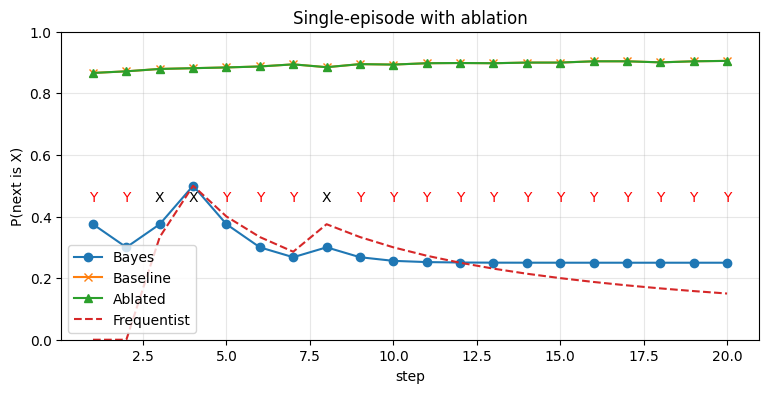

Baseline MAE: 0.6013972461905162 Bias: 0.6013972461905162
Ablated MAE: 0.6013972461905162 Bias: 0.6013972461905162


In [49]:
# single-episode demo with ablation (baseline vs ablated vs Bayes)

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    base = get_ab_logprobs(prompt, A_id, B_id)
    abl = None
    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        pA = float(probs[A_id].item())
        pB = float(probs[B_id].item())
        abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])
    freq_p = float(truth.iloc[-1]['freq_Phat_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'bayes_P_next_X': bayes_p,
        'model_P_next_X_base': base['pA_norm'],
        'model_P_next_X_ablated': abl,
        'freq_Phat_X': freq_p,
    })

abl_df = pd.DataFrame(rows)
display(abl_df.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(abl_df.step, abl_df.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(abl_df.step, abl_df.model_P_next_X_base, label='Baseline', marker='x')
if heads_to_ablate:
    ax.plot(abl_df.step, abl_df.model_P_next_X_ablated, label='Ablated', marker='^')
ax.plot(abl_df.step, abl_df.freq_Phat_X, label='Frequentist', linestyle='--')

for i, tok in enumerate(abl_df.obs_t):
    ax.annotate(tok, (abl_df.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode with ablation')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

mae_base = float((abl_df.model_P_next_X_base - abl_df.bayes_P_next_X).abs().mean())
bias_base = float((abl_df.model_P_next_X_base - abl_df.bayes_P_next_X).mean())

print('Baseline MAE:', mae_base, 'Bias:', bias_base)
if heads_to_ablate:
    mae_abl = float((abl_df.model_P_next_X_ablated - abl_df.bayes_P_next_X).abs().mean())
    bias_abl = float((abl_df.model_P_next_X_ablated - abl_df.bayes_P_next_X).mean())
    print('Ablated MAE:', mae_abl, 'Bias:', bias_abl)


In [50]:
# batch evaluation with ablation (baseline vs ablated)

rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq_batch = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq_batch[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
        base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']

        abl = None
        if heads_to_ablate:
            hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
            logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
            last = logits[0, -1, :]
            probs = torch.softmax(last.float(), dim=-1)
            pA = float(probs[A_id].item())
            pB = float(probs[B_id].item())
            abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'bayes_P_next_X': bayes_p,
            'model_P_next_X_base': base,
            'model_P_next_X_ablated': abl,
        })

all_df2 = pd.DataFrame(rows)

summary_rows = []
mae_base = float((all_df2.model_P_next_X_base - all_df2.bayes_P_next_X).abs().mean())
bias_base = float((all_df2.model_P_next_X_base - all_df2.bayes_P_next_X).mean())
corr_base = float(np.corrcoef(all_df2.model_P_next_X_base, all_df2.bayes_P_next_X)[0, 1])
summary_rows.append({'model': 'baseline', 'MAE': mae_base, 'Bias': bias_base, 'Corr': corr_base})

if heads_to_ablate:
    mae_abl = float((all_df2.model_P_next_X_ablated - all_df2.bayes_P_next_X).abs().mean())
    bias_abl = float((all_df2.model_P_next_X_ablated - all_df2.bayes_P_next_X).mean())
    corr_abl = float(np.corrcoef(all_df2.model_P_next_X_ablated, all_df2.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': 'ablated', 'MAE': mae_abl, 'Bias': bias_abl, 'Corr': corr_abl})

summary = pd.DataFrame(summary_rows)
display(summary)

base_stats = drift_stats_from_prompts(perm_prompts, hooks=None)
print('Baseline drift stats:', base_stats)

if heads_to_ablate:
    hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
    ablated_stats = drift_stats_from_prompts(perm_prompts, hooks=hooks)
    print('Ablated drift stats:', ablated_stats)
    rows_stats = []
    for key in base_stats:
        rows_stats.append({
            'metric': key,
            'baseline': base_stats[key],
            'ablated': ablated_stats[key],
            'reduction': base_stats[key] - ablated_stats[key],
        })
    display(pd.DataFrame(rows_stats))

summary.to_csv(os.path.join(output_dir, 'batch_summary_ablation.csv'), index=False)


episodes:   0%|          | 0/300 [00:00<?, ?it/s]

,model,MAE,Bias,Corr
0,baseline,0.410909,0.410909,-0.272384
1,ablated,0.410909,0.410909,-0.272384


Baseline drift stats: {'prob_std': 0.0029807514511048794, 'prob_max_min': 0.012391865253448486, 'logit_diff_std': 0.0321044921875, 'logit_diff_max_min': 0.1328125}
Ablated drift stats: {'prob_std': 0.0029807514511048794, 'prob_max_min': 0.012391865253448486, 'logit_diff_std': 0.0321044921875, 'logit_diff_max_min': 0.1328125}


,metric,baseline,ablated,reduction
0,prob_std,0.002981,0.002981,0.0
1,prob_max_min,0.012392,0.012392,0.0
2,logit_diff_std,0.032104,0.032104,0.0
3,logit_diff_max_min,0.132812,0.132812,0.0


In [51]:
# circuitVis attention visualization (baseline and ablated)

min_seq = perm_df_sorted.head(1).iloc[0]['seq'].split(' ')
max_seq = perm_df_sorted.tail(1).iloc[0]['seq'].split(' ')

for label, seq in [('min', min_seq), ('max', max_seq)]:
    prompt = build_prompt(seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
    print('===', label, 'prompt ===')
    print(prompt)
    logits, cache = model.run_with_cache(prompt)
    tokens = model.to_str_tokens(prompt)
    for layer in range(model.cfg.n_layers):
        patt = cache['pattern', layer][0].detach().cpu().numpy()
        display(cv.attention.attention_patterns(tokens=tokens, attention=patt, title=f'{label}: layer {layer} (baseline)'))

    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits2, cache2 = model.run_with_cache(prompt, fwd_hooks=hooks)
        for layer in range(model.cfg.n_layers):
            patt2 = cache2['pattern', layer][0].detach().cpu().numpy()
            display(cv.attention.attention_patterns(tokens=tokens, attention=patt2, title=f'{label}: layer {layer} (ablated)'))

print('Note: ablation changes outputs; attention patterns may be similar.')


=== min prompt ===
Two urns produce X/Y. Urn A produces X about 75%% of the time, Urn B produces X about 25%% of the time.
Observed sequence: Y Y Y Y Y Y X X X X X X.
Which is more likely next?
A) X
B) Y
Answer:


TypeError: attention_patterns() got an unexpected keyword argument 'title'

In [52]:
# probe config
probe_act_name = 'resid_post'  # 'resid_post' or 'resid_pre'
probe_position = 'answer_pos'  # last position
probe_train_size = 200
probe_type = "ridge"  # ridge recommended
# memory control: smaller batch reduces VRAM, per_layer caches only one layer at a time
probe_batch_size = 8
probe_cache_mode = 'per_layer'  # 'per_layer' or 'all_layers'


In [53]:
# probe dataset helpers (shared)

from collections import defaultdict
from sklearn.linear_model import Ridge

def generate_episode(pA, pB, prior, length):
    hidden = 'A' if random.random() < prior else 'B'
    pX = pA if hidden == 'A' else pB
    obs = ['X' if random.random() < pX else 'Y' for _ in range(length)]
    return hidden, obs

def get_target_logodds(obs_prefix, target):
    pA = bayes_update_posterior(prior_P_A, urn_A_pX, urn_B_pX, obs_prefix)
    if target == 'posterior_logodds':
        return logodds(pA)
    if target == 'predictive_logodds':
        p_next = bayes_predictive(pA, urn_A_pX, urn_B_pX)
        return logodds(p_next)
    raise ValueError('Unknown probe target')

def batch_by_length(prompts):
    groups = defaultdict(list)
    for i, p in enumerate(prompts):
        length = len(model.tokenizer.encode(p, add_special_tokens=False)) + 1
        groups[length].append(i)
    return groups

def _chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def build_probe_dataset(target, n_episodes, seq_len):
    prompts = []
    labels = []
    for _ in range(n_episodes):
        _, obs = generate_episode(urn_A_pX, urn_B_pX, prior_P_A, seq_len)
        for t in range(1, seq_len + 1):
            prefix = obs[:t]
            prompts.append(build_prompt(prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))
            labels.append(get_target_logodds(prefix, target))
    labels = np.array(labels, dtype=np.float32)

    X_by_layer = {layer: [] for layer in range(model.cfg.n_layers)}
    idx_groups = batch_by_length(prompts)

    with torch.no_grad():
        for length, idxs in tqdm(idx_groups.items(), desc=f'probe extract ({target})'):
            for chunk in _chunks(idxs, probe_batch_size):
                batch_prompts = [prompts[i] for i in chunk]
                tokens = model.to_tokens(batch_prompts, prepend_bos=True)

                if probe_cache_mode == 'all_layers':
                    names = [get_act_name(probe_act_name, layer) for layer in range(model.cfg.n_layers)]
                    _, cache = model.run_with_cache(tokens, names_filter=names)
                    for layer in range(model.cfg.n_layers):
                        act = cache[probe_act_name, layer][:, -1, :].detach().cpu().numpy()
                        X_by_layer[layer].append(act)
                    del cache
                else:
                    for layer in range(model.cfg.n_layers):
                        name = get_act_name(probe_act_name, layer)
                        _, cache = model.run_with_cache(tokens, names_filter=[name], stop_at_layer=layer + 1)
                        act = cache[probe_act_name, layer][:, -1, :].detach().cpu().numpy()
                        X_by_layer[layer].append(act)
                        del cache

                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    for layer in X_by_layer:
        X_by_layer[layer] = np.concatenate(X_by_layer[layer], axis=0)

    print('Probe dataset shape example:', X_by_layer[0].shape, 'labels:', labels.shape)
    return prompts, labels, X_by_layer

def train_probes_all_layers(X_by_layer, labels, tag):
    results = []
    probe_weights = {}

    n_total = len(labels)
    idx = np.arange(n_total)
    np.random.shuffle(idx)
    split = int(0.8 * n_total)
    train_idx, test_idx = idx[:split], idx[split:]

    for layer in tqdm(range(model.cfg.n_layers), desc=f'probe train ({tag})'):
        X = X_by_layer[layer]
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = labels[train_idx], labels[test_idx]

        if probe_type == 'ridge':
            reg = Ridge(alpha=1.0, fit_intercept=True)
            reg.fit(X_tr, y_tr)
            w = reg.coef_
            b = float(reg.intercept_)
        else:
            raise ValueError('Only ridge implemented in this notebook')

        pred = X_te @ w + b
        pred_p = 1 / (1 + np.exp(-pred))
        true_p = 1 / (1 + np.exp(-y_te))

        mae = float(np.mean(np.abs(pred_p - true_p)))
        mse = float(np.mean((pred - y_te) ** 2))
        corr = float(np.corrcoef(pred_p, true_p)[0, 1])

        results.append({'layer': layer, 'MAE': mae, 'MSE_logodds': mse, 'Corr': corr})
        probe_weights[layer] = (w, b)

        np.save(os.path.join(output_dir, f'probe_w_layer{layer}_{tag}.npy'), w.astype(np.float32))
        np.save(os.path.join(output_dir, f'probe_b_layer{layer}_{tag}.npy'), np.array([b], dtype=np.float32))

    res_df = pd.DataFrame(results).sort_values('MAE')
    display(res_df.head(10))
    res_df.to_csv(os.path.join(output_dir, f'probe_results_{tag}.csv'), index=False)
    return res_df, probe_weights


In [54]:
# train probes: posterior logodds
probe_target = 'posterior_logodds'
_, labels_post, X_by_layer_post = build_probe_dataset(probe_target, probe_train_size, seq_len_batch)
res_df_posterior, probe_weights_posterior = train_probes_all_layers(X_by_layer_post, labels_post, tag='posterior')


probe extract (posterior_logodds):   0%|          | 0/20 [00:00<?, ?it/s]

Probe dataset shape example: (4000, 512) labels: (4000,)


probe train (posterior):   0%|          | 0/3 [00:00<?, ?it/s]

,layer,MAE,MSE_logodds,Corr
2,2,0.374788,51.883515,0.259838
1,1,0.380214,52.135111,0.247434
0,0,0.381113,52.063876,0.254261


In [55]:
# train probes: predictive logodds
probe_target = 'predictive_logodds'
_, labels_pred, X_by_layer_pred = build_probe_dataset(probe_target, probe_train_size, seq_len_batch)
res_df_predictive, probe_weights_predictive = train_probes_all_layers(X_by_layer_pred, labels_pred, tag='predictive')


probe extract (predictive_logodds):   0%|          | 0/20 [00:00<?, ?it/s]

Probe dataset shape example: (4000, 512) labels: (4000,)


probe train (predictive):   0%|          | 0/3 [00:00<?, ?it/s]

,layer,MAE,MSE_logodds,Corr
2,2,0.197673,0.851079,0.260716
1,1,0.198774,0.850991,0.271082
0,0,0.200642,0.858961,0.259327


,step,obs_t,bayes_P_next_X,baseline_P_next_X,ablated_P_next_X,probe_P_next_X
0,1,Y,0.375,0.866133,0.866133,0.846148
1,2,Y,0.300,0.871475,0.871475,0.964507
2,3,X,0.375,0.879147,0.879147,0.462649
3,4,X,0.500,0.881615,0.881615,0.798583
4,5,Y,0.375,0.884039,0.884039,0.339598


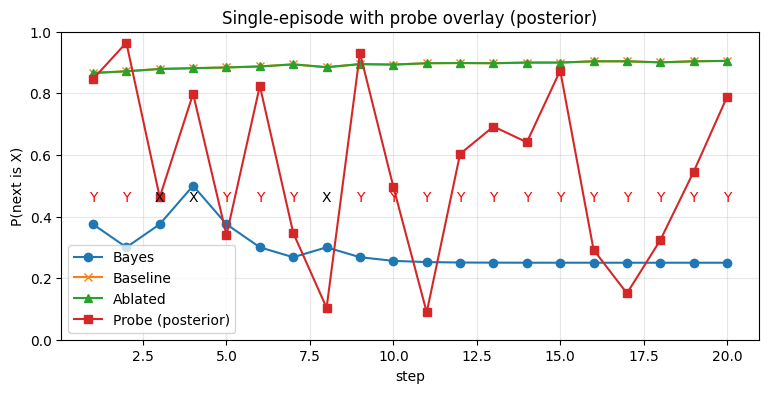

baseline_P_next_X MAE 0.6013972461905162 Bias 0.6013972461905162
probe_P_next_X MAE 0.31409967435334024 Bias 0.2646679144977063


In [56]:
# probe overlay (posterior)
posterior_probe_layer = int(res_df_posterior.iloc[0]['layer'])
w_post, b_post = probe_weights_posterior[posterior_probe_layer]

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
    abl = None
    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        pA = float(probs[A_id].item())
        pB = float(probs[B_id].item())
        abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

    tokens = model.to_tokens(prompt, prepend_bos=True)
    logits, cache = model.run_with_cache(tokens)
    act = cache[probe_act_name, posterior_probe_layer][0, -1, :].detach().cpu().numpy()
    pred_logodds = act @ w_post + b_post
    probe_p = 1 / (1 + np.exp(-pred_logodds))

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'bayes_P_next_X': bayes_p,
        'baseline_P_next_X': base,
        'ablated_P_next_X': abl,
        'probe_P_next_X': float(probe_p),
    })

probe_df_post = pd.DataFrame(rows)
display(probe_df_post.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(probe_df_post.step, probe_df_post.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(probe_df_post.step, probe_df_post.baseline_P_next_X, label='Baseline', marker='x')
if heads_to_ablate:
    ax.plot(probe_df_post.step, probe_df_post.ablated_P_next_X, label='Ablated', marker='^')
ax.plot(probe_df_post.step, probe_df_post.probe_P_next_X, label='Probe (posterior)', marker='s')

for i, tok in enumerate(probe_df_post.obs_t):
    ax.annotate(tok, (probe_df_post.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode with probe overlay (posterior)')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

for name in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((probe_df_post[name] - probe_df_post.bayes_P_next_X).abs().mean())
    bias = float((probe_df_post[name] - probe_df_post.bayes_P_next_X).mean())
    print(name, 'MAE', mae, 'Bias', bias)


,step,obs_t,bayes_P_next_X,baseline_P_next_X,ablated_P_next_X,probe_P_next_X
0,1,Y,0.375,0.866133,0.866133,0.477754
1,2,Y,0.300,0.871475,0.871475,0.477178
2,3,X,0.375,0.879147,0.879147,0.546193
3,4,X,0.500,0.881615,0.881615,0.530774
4,5,Y,0.375,0.884039,0.884039,0.514279


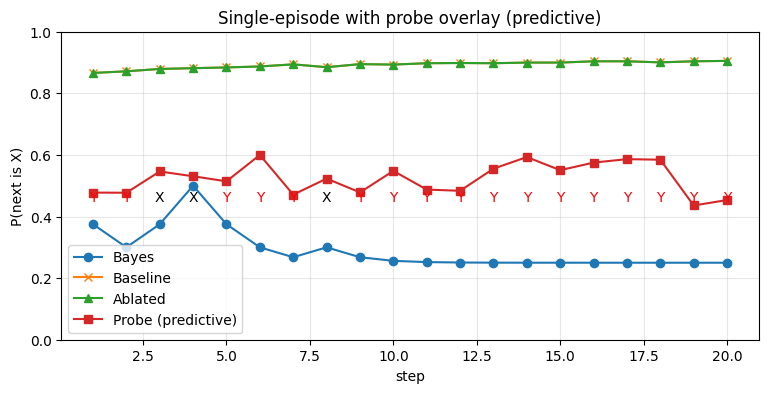

baseline_P_next_X MAE 0.6013972461905162 Bias 0.6013972461905162
probe_P_next_X MAE 0.23258577734735106 Bias 0.23258577734735106


In [57]:
# probe overlay (predictive)
predictive_probe_layer = int(res_df_predictive.iloc[0]['layer'])
w_pred, b_pred = probe_weights_predictive[predictive_probe_layer]

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
    abl = None
    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        pA = float(probs[A_id].item())
        pB = float(probs[B_id].item())
        abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

    tokens = model.to_tokens(prompt, prepend_bos=True)
    logits, cache = model.run_with_cache(tokens)
    act = cache[probe_act_name, predictive_probe_layer][0, -1, :].detach().cpu().numpy()
    pred_logodds = act @ w_pred + b_pred
    probe_p = 1 / (1 + np.exp(-pred_logodds))

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'bayes_P_next_X': bayes_p,
        'baseline_P_next_X': base,
        'ablated_P_next_X': abl,
        'probe_P_next_X': float(probe_p),
    })

probe_df_pred = pd.DataFrame(rows)
display(probe_df_pred.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(probe_df_pred.step, probe_df_pred.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(probe_df_pred.step, probe_df_pred.baseline_P_next_X, label='Baseline', marker='x')
if heads_to_ablate:
    ax.plot(probe_df_pred.step, probe_df_pred.ablated_P_next_X, label='Ablated', marker='^')
ax.plot(probe_df_pred.step, probe_df_pred.probe_P_next_X, label='Probe (predictive)', marker='s')

for i, tok in enumerate(probe_df_pred.obs_t):
    ax.annotate(tok, (probe_df_pred.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode with probe overlay (predictive)')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

for name in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((probe_df_pred[name] - probe_df_pred.bayes_P_next_X).abs().mean())
    bias = float((probe_df_pred[name] - probe_df_pred.bayes_P_next_X).mean())
    print(name, 'MAE', mae, 'Bias', bias)


In [58]:
# batch evaluation with probe (posterior)
rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq_batch = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq_batch[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

        base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
        abl = None
        if heads_to_ablate:
            hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
            logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
            last = logits[0, -1, :]
            probs = torch.softmax(last.float(), dim=-1)
            pA = float(probs[A_id].item())
            pB = float(probs[B_id].item())
            abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

        tokens = model.to_tokens(prompt, prepend_bos=True)
        logits, cache = model.run_with_cache(tokens)
        act = cache[probe_act_name, posterior_probe_layer][0, -1, :].detach().cpu().numpy()
        pred_logodds = act @ w_post + b_post
        probe_p = 1 / (1 + np.exp(-pred_logodds))

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'bayes_P_next_X': bayes_p,
            'baseline_P_next_X': base,
            'ablated_P_next_X': abl,
            'probe_P_next_X': float(probe_p),
        })

all_df_post = pd.DataFrame(rows)

summary_rows = []
for col in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((all_df_post[col] - all_df_post.bayes_P_next_X).abs().mean())
    bias = float((all_df_post[col] - all_df_post.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df_post[col], all_df_post.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

if heads_to_ablate:
    col = 'ablated_P_next_X'
    mae = float((all_df_post[col] - all_df_post.bayes_P_next_X).abs().mean())
    bias = float((all_df_post[col] - all_df_post.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df_post[col], all_df_post.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

summary_post = pd.DataFrame(summary_rows)
display(summary_post)
summary_post.to_csv(os.path.join(output_dir, 'batch_summary_with_probe_posterior.csv'), index=False)


episodes:   0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# batch evaluation with probe (predictive)
rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq_batch = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq_batch[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

        base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
        abl = None
        if heads_to_ablate:
            hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
            logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
            last = logits[0, -1, :]
            probs = torch.softmax(last.float(), dim=-1)
            pA = float(probs[A_id].item())
            pB = float(probs[B_id].item())
            abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

        tokens = model.to_tokens(prompt, prepend_bos=True)
        logits, cache = model.run_with_cache(tokens)
        act = cache[probe_act_name, predictive_probe_layer][0, -1, :].detach().cpu().numpy()
        pred_logodds = act @ w_pred + b_pred
        probe_p = 1 / (1 + np.exp(-pred_logodds))

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'bayes_P_next_X': bayes_p,
            'baseline_P_next_X': base,
            'ablated_P_next_X': abl,
            'probe_P_next_X': float(probe_p),
        })

all_df_pred = pd.DataFrame(rows)

summary_rows = []
for col in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((all_df_pred[col] - all_df_pred.bayes_P_next_X).abs().mean())
    bias = float((all_df_pred[col] - all_df_pred.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df_pred[col], all_df_pred.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

if heads_to_ablate:
    col = 'ablated_P_next_X'
    mae = float((all_df_pred[col] - all_df_pred.bayes_P_next_X).abs().mean())
    bias = float((all_df_pred[col] - all_df_pred.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df_pred[col], all_df_pred.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

summary_pred = pd.DataFrame(summary_rows)
display(summary_pred)
summary_pred.to_csv(os.path.join(output_dir, 'batch_summary_with_probe_predictive.csv'), index=False)


In [ ]:
# select belief-probe for causal validation
belief_probe_kind = 'posterior'  # 'posterior' or 'predictive'

if belief_probe_kind == 'posterior':
    chosen_probe_layer = posterior_probe_layer
    w = w_post
    b = b_post
elif belief_probe_kind == 'predictive':
    chosen_probe_layer = predictive_probe_layer
    w = w_pred
    b = b_pred
else:
    raise ValueError('Unknown belief_probe_kind')

print('Belief probe for causal validation:', belief_probe_kind, 'layer', chosen_probe_layer)


In [ ]:
# belief editing and belief swapping (causal validation)
layer_to_edit = chosen_probe_layer
edit_lambda = 5.0

probe_dir = w / (np.linalg.norm(w) + 1e-8)
probe_dir_t = torch.tensor(probe_dir, device=DEVICE, dtype=torch.float32)


def belief_edit_hook(act, hook, direction, scale):
    act[:, -1, :] = act[:, -1, :] + scale * direction
    return act

example_seq = ['X','Y','X','Y','X','Y']
example_prompt = build_prompt(example_seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

base = get_ab_logprobs(example_prompt, A_id, B_id)['pA_norm']

if probe_act_name == 'resid_post':
    hook_name = f'blocks.{layer_to_edit}.hook_resid_post'
elif probe_act_name == 'resid_pre':
    hook_name = f'blocks.{layer_to_edit}.hook_resid_pre'
else:
    raise ValueError('Unsupported probe_act_name for editing')

logits = model.run_with_hooks(example_prompt, fwd_hooks=[(hook_name, lambda act, hook: belief_edit_hook(act, hook, probe_dir_t, edit_lambda))])
last = logits[0, -1, :]
probs = torch.softmax(last.float(), dim=-1)
edit_pA = float(probs[A_id].item())
edit_pB = float(probs[B_id].item())
edit = edit_pA / (edit_pA + edit_pB) if (edit_pA + edit_pB) > 0 else 0.5

print('Baseline P(X):', base)
print('Edited   P(X):', edit, '(lambda=', edit_lambda, ')')
print('Belief swapping is left as an exercise: patch the probe component between two runs.')


# Causal validation: belief-subspace patching (necessity & sufficiency)


In [ ]:
# Causal validation: belief-subspace patching (necessity & sufficiency)

# Parameters
PATCH_LAYER = chosen_probe_layer
PATCH_MODE = 'swap'  # 'swap' | 'remove' | 'edit'
DELTA_STRENGTH = 1.0
PATCH_T = min(10, seq_len_single)
MIN_POST_GAP = 0.3
N_PAIRS = 20

# Belief direction
v = w / (np.linalg.norm(w) + 1e-8)
v_t = torch.tensor(v, device=DEVICE, dtype=torch.float32)


def proj_v(x, v):
    return (x @ v) * v


def binary_kl(p, q):
    eps = 1e-9
    p = max(eps, min(1 - eps, float(p)))
    q = max(eps, min(1 - eps, float(q)))
    return p * math.log(p / q) + (1 - p) * math.log((1 - p) / (1 - q))


def infer_pA_from_pred(p_next_x, pA, pB):
    denom = (pA - pB)
    if abs(denom) < 1e-8:
        return 0.5
    pA_post = (p_next_x - pB) / denom
    return max(0.0, min(1.0, pA_post))


def sample_prefix(t, forced_urn=None):
    if forced_urn is None:
        hidden = 'A' if random.random() < prior_P_A else 'B'
    else:
        hidden = forced_urn
    pX = urn_A_pX if hidden == 'A' else urn_B_pX
    seq = ['X' if random.random() < pX else 'Y' for _ in range(t)]
    return hidden, seq


def sample_prefix_pair(t, min_gap=0.3, max_tries=200):
    best = None
    for _ in range(max_tries):
        h1, s1 = sample_prefix(t, forced_urn='A')
        h2, s2 = sample_prefix(t, forced_urn='B')
        pA1 = bayes_update_posterior(prior_P_A, urn_A_pX, urn_B_pX, s1)
        pA2 = bayes_update_posterior(prior_P_A, urn_A_pX, urn_B_pX, s2)
        if abs(pA1 - pA2) >= min_gap:
            return (h1, s1, pA1), (h2, s2, pA2)
        best = (h1, s1, pA1, h2, s2, pA2)
    if best is not None:
        h1, s1, pA1, h2, s2, pA2 = best
        return (h1, s1, pA1), (h2, s2, pA2)
    return None


def get_resid_at_layer(prompt, layer):
    tokens = model.to_tokens(prompt, prepend_bos=True)
    logits, cache = model.run_with_cache(tokens)
    resid = cache[probe_act_name, layer][0, -1, :].detach()
    return resid, logits


def readout_from_logits(logits):
    last = logits[0, -1, :]
    logit_A = float(last[A_id].item())
    logit_B = float(last[B_id].item())
    probs = torch.softmax(last.float(), dim=-1)
    pA = float(probs[A_id].item())
    pB = float(probs[B_id].item())
    denom = pA + pB
    pA_norm = pA / denom if denom > 0 else 0.5
    return {
        'pA_norm': pA_norm,
        'logit_diff': logit_A - logit_B,
    }


def patch_resid_fn(resid, hook, v, mode, donor_resid=None, delta=1.0):
    r = resid[:, -1, :]
    if mode == 'remove':
        r = r - proj_v(r, v)
    elif mode == 'edit':
        r = r + delta * v
    elif mode == 'swap':
        if donor_resid is None:
            raise ValueError('donor_resid required for swap')
        r = r - proj_v(r, v) + proj_v(donor_resid, v)
    else:
        raise ValueError('Unknown PATCH_MODE')
    resid[:, -1, :] = r
    return resid

if probe_act_name == 'resid_post':
    hook_name = f'blocks.{PATCH_LAYER}.hook_resid_post'
elif probe_act_name == 'resid_pre':
    hook_name = f'blocks.{PATCH_LAYER}.hook_resid_pre'
else:
    raise ValueError('Unsupported probe_act_name')

rows = []
for i in range(N_PAIRS):
    pair = sample_prefix_pair(PATCH_T, min_gap=MIN_POST_GAP)
    (h1, s1, pA1), (h2, s2, pA2) = pair

    prompt1 = build_prompt(s1, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
    prompt2 = build_prompt(s2, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    resid1, logits1 = get_resid_at_layer(prompt1, PATCH_LAYER)
    resid2, logits2 = get_resid_at_layer(prompt2, PATCH_LAYER)

    base1 = readout_from_logits(logits1)

    donor = resid2

    def hook_fn(resid, hook):
        return patch_resid_fn(resid, hook, v_t, PATCH_MODE, donor_resid=donor, delta=DELTA_STRENGTH)

    patched_logits = model.run_with_hooks(prompt1, fwd_hooks=[(hook_name, hook_fn)])
    patched = readout_from_logits(patched_logits)

    bayes_p1 = bayes_predictive(pA1, urn_A_pX, urn_B_pX)

    rows.append({
        'pair': i,
        'seq1': ' '.join(s1),
        'seq2': ' '.join(s2),
        'bayes_p_next_X': bayes_p1,
        'base_pA': base1['pA_norm'],
        'patched_pA': patched['pA_norm'],
        'delta_logit_diff': patched['logit_diff'] - base1['logit_diff'],
        'kl_base': binary_kl(bayes_p1, base1['pA_norm']),
        'kl_patched': binary_kl(bayes_p1, patched['pA_norm']),
    })

patch_df = pd.DataFrame(rows)
display(patch_df)

if len(patch_df) > 0:
    print('Mean delta logit diff:', patch_df.delta_logit_diff.mean())
    print('Mean KL (base):', patch_df.kl_base.mean())
    print('Mean KL (patched):', patch_df.kl_patched.mean())


# Causal validation: forced belief edits + update coherence


In [ ]:
# Causal validation: forced belief edits + update coherence

LAMBDA_GRID = [-10, -5, -2, -1, 0, 1, 2, 5, 10]
EDIT_T = min(10, seq_len_single)

obs_prefix = obs_seq[:EDIT_T]
base_prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

if probe_act_name == 'resid_post':
    hook_name = f'blocks.{PATCH_LAYER}.hook_resid_post'
elif probe_act_name == 'resid_pre':
    hook_name = f'blocks.{PATCH_LAYER}.hook_resid_pre'
else:
    raise ValueError('Unsupported probe_act_name')


def edit_hook(resid, hook, direction, scale):
    resid[:, -1, :] = resid[:, -1, :] + scale * direction
    return resid

rows = []
for lam in LAMBDA_GRID:
    logits = model.run_with_hooks(base_prompt, fwd_hooks=[(hook_name, lambda resid, hook, lam=lam: edit_hook(resid, hook, v_t, lam))])
    out = readout_from_logits(logits)
    rows.append({'lambda': lam, 'pA_norm': out['pA_norm'], 'logit_diff': out['logit_diff']})

edit_df = pd.DataFrame(rows)
display(edit_df)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(edit_df['lambda'], edit_df['pA_norm'], marker='o')
ax.set_title('Belief edit dose-response')
ax.set_xlabel('lambda')
ax.set_ylabel('P(A | {A,B})')
ax.grid(True, alpha=0.3)
plt.show()

future_obs = obs_seq[EDIT_T:EDIT_T+3]
if len(future_obs) == 0:
    pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    future_obs = ['X' if random.random() < pX else 'Y' for _ in range(3)]

coh_rows = []
for lam in [-5, 0, 5]:
    logits = model.run_with_hooks(base_prompt, fwd_hooks=[(hook_name, lambda resid, hook, lam=lam: edit_hook(resid, hook, v_t, lam))])
    out = readout_from_logits(logits)
    pA_edited = infer_pA_from_pred(out['pA_norm'], urn_A_pX, urn_B_pX)

    pA_curr = pA_edited
    for k in range(1, len(future_obs) + 1):
        obs_k = future_obs[:k]
        for obs in obs_k:
            if obs == 'X':
                lik_A = urn_A_pX
                lik_B = urn_B_pX
            else:
                lik_A = 1 - urn_A_pX
                lik_B = 1 - urn_B_pX
            unnorm_A = lik_A * pA_curr
            unnorm_B = lik_B * (1 - pA_curr)
            denom = unnorm_A + unnorm_B
            pA_curr = unnorm_A / denom if denom > 0 else 0.5

        bayes_next = bayes_predictive(pA_curr, urn_A_pX, urn_B_pX)

        prompt_k = build_prompt(obs_prefix + obs_k, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
        logits_k = model.run_with_hooks(prompt_k, fwd_hooks=[(hook_name, lambda resid, hook, lam=lam: edit_hook(resid, hook, v_t, lam))])
        out_k = readout_from_logits(logits_k)

        coh_rows.append({
            'lambda': lam,
            'k': k,
            'obs_k': ''.join(obs_k),
            'bayes_from_edit': bayes_next,
            'model_edit_pred': out_k['pA_norm'],
        })

coh_df = pd.DataFrame(coh_rows)
display(coh_df)

if len(coh_df) > 0:
    coh_df['abs_err'] = (coh_df.model_edit_pred - coh_df.bayes_from_edit).abs()
    print('Mean abs error (update coherence):', coh_df.abs_err.mean())


# (Optional but recommended) Path patching / edge attribution for update vs readout


In [ ]:
# (Optional but recommended) Path patching / edge attribution for update vs readout

# (1) Write-to-logits attribution
u = model.W_U[:, A_id] - model.W_U[:, B_id]  # unembedding direction

# Choose a representative prompt from drift extremes if available
if 'perm_df_sorted' in globals():
    min_seq = perm_df_sorted.head(1).iloc[0]['seq'].split(' ')
    max_seq = perm_df_sorted.tail(1).iloc[0]['seq'].split(' ')
else:
    min_seq = ['Y'] * drift_counts_total_N
    max_seq = ['X'] * drift_counts_total_N

prompt = build_prompt(max_seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
logits, cache = model.run_with_cache(prompt)

rows = []
for layer in range(model.cfg.n_layers):
    head_out = cache['attn.hook_result', layer][0, -1, :, :]  # [head, d_model]
    for head in range(model.cfg.n_heads):
        contrib = float((head_out[head] @ u).item())
        rows.append({'layer': layer, 'head': head, 'contrib_to_logit_diff': contrib})

attr_df = pd.DataFrame(rows).sort_values('contrib_to_logit_diff', ascending=False)
print('Top positive contributors:')
display(attr_df.head(10))
print('Top negative contributors:')
display(attr_df.tail(10))

# (2) Path patching (clean -> corrupt) using head outputs
PATCH_LAYER_RANGE = list(range(model.cfg.n_layers))  # full scan for rigor

clean_seq = ['X'] * (drift_counts_total_N)  # evidence for urn A
corrupt_seq = ['Y'] * (drift_counts_total_N)  # evidence for urn B

clean_prompt = build_prompt(clean_seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
corrupt_prompt = build_prompt(corrupt_seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

clean_logits, clean_cache = model.run_with_cache(clean_prompt)
corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_prompt)

clean_ld = readout_from_logits(clean_logits)['logit_diff']
corrupt_ld = readout_from_logits(corrupt_logits)['logit_diff']

patch_rows = []
for layer in PATCH_LAYER_RANGE:
    hook_name = f'blocks.{layer}.attn.hook_result'
    for head in range(model.cfg.n_heads):
        def hook_fn(act, hook, head=head, layer=layer):
            act[:, :, head, :] = clean_cache[hook_name][:, :, head, :]
            return act
        patched_logits = model.run_with_hooks(corrupt_prompt, fwd_hooks=[(hook_name, hook_fn)])
        patched_ld = readout_from_logits(patched_logits)['logit_diff']
        patch_rows.append({
            'layer': layer,
            'head': head,
            'clean_ld': clean_ld,
            'corrupt_ld': corrupt_ld,
            'patched_ld': patched_ld,
            'recovery': patched_ld - corrupt_ld,
        })

patch_df = pd.DataFrame(patch_rows).sort_values('recovery', ascending=False)
print('Top patch-recovery heads:')
display(patch_df.head(10))


# Invariance & robustness suite (avoid prompt artifacts)


In [ ]:
# Invariance & robustness suite (avoid prompt artifacts)

# robustness config
# Larger values -> more rigorous, slower
ROBUST_EPISODES = 300
ROBUST_PERMS = 256
ROBUST_SEEDS = [0, 1, 2]

# Helper: evaluate behavior metrics

def eval_behavior(n_eps, seq_len, pA_x, pB_x, prior, template_id, answer_map=None, distractor=None):
    rows = []
    for seed in ROBUST_SEEDS:
        rng = np.random.default_rng(seed)
        for _ in range(n_eps):
            hidden = 'A' if rng.random() < prior else 'B'
            pX = pA_x if hidden == 'A' else pB_x
            obs = ['X' if rng.random() < pX else 'Y' for _ in range(seq_len)]
            for t in range(1, seq_len + 1):
                prefix = obs[:t]
                prompt = build_prompt(prefix, pA_x, pB_x, prior, template_id)
                if distractor:
                    prompt = prompt.replace('Answer:', f'{distractor}\nAnswer:')
                out = get_ab_logprobs(prompt, A_id, B_id)
                p_model = out['pA_norm']
                if answer_map == 'swap':
                    p_model = 1 - p_model
                pA_post = bayes_update_posterior(prior, pA_x, pB_x, prefix)
                p_bayes = bayes_predictive(pA_post, pA_x, pB_x)
                rows.append({'p_model': p_model, 'p_bayes': p_bayes})
    df = pd.DataFrame(rows)
    mae = float((df.p_model - df.p_bayes).abs().mean())
    bias = float((df.p_model - df.p_bayes).mean())
    corr = float(np.corrcoef(df.p_model, df.p_bayes)[0, 1])
    return mae, bias, corr

# Helper: drift metrics (both readouts, both metrics)

def eval_drift_all(n_perm, n_total, n_x, pA_x, pB_x, prior, template_id, answer_map=None):
    base_seq = ['X'] * n_x + ['Y'] * (n_total - n_x)
    preds = []
    logit_diffs = []
    for seed in ROBUST_SEEDS:
        rng = np.random.default_rng(seed)
        for _ in range(n_perm):
            seq = base_seq.copy()
            rng.shuffle(seq)
            prompt = build_prompt(seq, pA_x, pB_x, prior, template_id)
            out = get_ab_logprobs(prompt, A_id, B_id)
            p = out['pA_norm']
            if answer_map == 'swap':
                p = 1 - p
            preds.append(p)
            logit_diffs.append(out['logit_A'] - out['logit_B'])

    preds = np.array(preds)
    logit_diffs = np.array(logit_diffs)
    return {
        'drift_prob_std': float(np.std(preds)),
        'drift_prob_max_min': float(preds.max() - preds.min()),
        'drift_logit_std': float(np.std(logit_diffs)),
        'drift_logit_max_min': float(logit_diffs.max() - logit_diffs.min()),
    }

# Helper: probe metric if available

def eval_probe(n_eps, seq_len, pA_x, pB_x, prior, template_id):
    if 'w' not in globals() or 'b' not in globals():
        return None
    rows = []
    for seed in ROBUST_SEEDS:
        rng = np.random.default_rng(seed)
        for _ in range(n_eps):
            hidden = 'A' if rng.random() < prior else 'B'
            pX = pA_x if hidden == 'A' else pB_x
            obs = ['X' if rng.random() < pX else 'Y' for _ in range(seq_len)]
            for t in range(1, seq_len + 1):
                prefix = obs[:t]
                prompt = build_prompt(prefix, pA_x, pB_x, prior, template_id)
                tokens = model.to_tokens(prompt, prepend_bos=True)
                logits, cache = model.run_with_cache(tokens)
                act = cache[probe_act_name, chosen_probe_layer][0, -1, :].detach().cpu().numpy()
                pred_logodds = act @ w + b
                p_probe = 1 / (1 + np.exp(-pred_logodds))
                pA_post = bayes_update_posterior(prior, pA_x, pB_x, prefix)
                p_bayes = bayes_predictive(pA_post, pA_x, pB_x)
                rows.append({'p_probe': p_probe, 'p_bayes': p_bayes})
    df = pd.DataFrame(rows)
    mae = float((df.p_probe - df.p_bayes).abs().mean())
    return mae

results = []

# (1) Symbol swap
mae, bias, corr = eval_behavior(ROBUST_EPISODES, seq_len_batch, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version, answer_map='swap')
drift_stats = eval_drift_all(ROBUST_PERMS, drift_counts_total_N, drift_counts_nX, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version, answer_map='swap')
probe_mae = eval_probe(20, 10, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
row = {'condition': 'symbol_swap', 'MAE': mae, 'Bias': bias, 'Corr': corr, 'Probe_MAE': probe_mae}
row.update(drift_stats)
results.append(row)

# (2) Paraphrase templates
for tid in ['v0','v1','v2','v3']:
    mae, bias, corr = eval_behavior(ROBUST_EPISODES, seq_len_batch, urn_A_pX, urn_B_pX, prior_P_A, tid)
    drift_stats = eval_drift_all(ROBUST_PERMS, drift_counts_total_N, drift_counts_nX, urn_A_pX, urn_B_pX, prior_P_A, tid)
    probe_mae = eval_probe(20, 10, urn_A_pX, urn_B_pX, prior_P_A, tid)
    row = {'condition': f'template_{tid}', 'MAE': mae, 'Bias': bias, 'Corr': corr, 'Probe_MAE': probe_mae}
    row.update(drift_stats)
    results.append(row)

# (3) Distractors
DISTRACTOR = 'Irrelevant note: the sky is blue.'
mae, bias, corr = eval_behavior(ROBUST_EPISODES, seq_len_batch, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version, distractor=DISTRACTOR)
drift_stats = eval_drift_all(ROBUST_PERMS, drift_counts_total_N, drift_counts_nX, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
probe_mae = eval_probe(20, 10, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
row = {'condition': 'distractor', 'MAE': mae, 'Bias': bias, 'Corr': corr, 'Probe_MAE': probe_mae}
row.update(drift_stats)
results.append(row)

# (4) Parameter generalization
for pA_x, pB_x in [(0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]:
    mae, bias, corr = eval_behavior(ROBUST_EPISODES, seq_len_batch, pA_x, pB_x, prior_P_A, prompt_template_version)
    drift_stats = eval_drift_all(ROBUST_PERMS, drift_counts_total_N, drift_counts_nX, pA_x, pB_x, prior_P_A, prompt_template_version)
    probe_mae = eval_probe(20, 10, pA_x, pB_x, prior_P_A, prompt_template_version)
    row = {'condition': f'params_{pA_x}_{pB_x}', 'MAE': mae, 'Bias': bias, 'Corr': corr, 'Probe_MAE': probe_mae}
    row.update(drift_stats)
    results.append(row)

robust_df = pd.DataFrame(results)
display(robust_df)
robust_df.to_csv(os.path.join(output_dir, 'robustness_summary.csv'), index=False)
